## Required library is imported

In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import backend as K
from tensorflow.keras.layers import Dense, Activation,Dropout,Conv2D, MaxPooling2D,BatchNormalization, Flatten, Add, AveragePooling2D, Input, ZeroPadding2D
from tensorflow.keras.layers import Activation, BatchNormalization, Add, Reshape, DepthwiseConv2D, GlobalAveragePooling2D

from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras import regularizers
from tensorflow.keras.initializers import glorot_uniform
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model, load_model, Sequential
import numpy as np
import pandas as pd
import shutil
import time
from tensorflow.keras import layers


from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
import os
import seaborn as sns
sns.set_style('darkgrid')
from PIL import Image
from sklearn.metrics import confusion_matrix, classification_report

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
from tensorflow.keras.metrics import Recall

## Datasets is imported

In [3]:
data_dir = r'/kaggle/input/lung-and-colon-cancer-histopathological-images/lung_colon_image_set/'

filepaths = []
labels = []


for root, dirs, files in os.walk(data_dir):
    for klass in dirs:
        if klass in ["lung_image_sets", "colon_image_sets"]:
            continue  # Skip the main classes, only consider subclasses
        classpath = os.path.join(root, klass)
        flist = os.listdir(classpath)
        for f in flist:
            fpath = os.path.join(classpath, f)
            filepaths.append(fpath)
            labels.append(klass)

Fseries = pd.Series(filepaths, name='filepaths')
Lseries = pd.Series(labels, name='labels')
data_df = pd.concat([Fseries, Lseries], axis=1)
df = data_df.reset_index(drop=True)  # Make a combined dataframe

print(df['labels'].value_counts())

labels
colon_aca    5000
colon_n      5000
lung_aca     5000
lung_scc     5000
lung_n       5000
Name: count, dtype: int64


In [4]:
sample_size=5000
sample_list=[]
group=df.groupby('labels')
for label in df['labels'].unique():    
    label_group=group.get_group(label).sample(sample_size, replace=False, random_state=123, axis=0)    
    sample_list.append(label_group)
df=pd.concat(sample_list, axis=0).reset_index(drop=True)
print (len(df))

25000


## Spliting the data into training and test datasets

In [5]:
train_split=.8
test_split=.1
dummy_split=test_split/(1-train_split)
train_df, dummy_df=train_test_split(df, train_size=train_split, shuffle=True, random_state=123)
test_df, valid_df=train_test_split(dummy_df, train_size=dummy_split, shuffle=True, random_state=123)
print ('train_df length: ', len(train_df), ' test_df length: ', len(test_df), '  valid_df length: ', len(valid_df))

train_df length:  20000  test_df length:  2500   valid_df length:  2500


## Data Visualizing and  Preprocessing

In [6]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
height=224
width=224
channels=3
batch_size=32
img_shape=(height, width, channels)
img_size=(height, width)
length=len(test_df)
test_batch_size=sorted([int(length/n) for n in range(1,length+1) if length % n ==0 and length/n<=80],reverse=True)[0]  
test_steps=int(length/test_batch_size)
print ( 'test batch size: ' ,test_batch_size, '  test steps: ', test_steps)
def scalar(img):
    return img/127.5-1  # scale pixel between -1 and +1
gen=ImageDataGenerator(preprocessing_function=scalar)
train_gen=gen.flow_from_dataframe( train_df, x_col='filepaths', y_col='labels', target_size=img_size, class_mode='categorical',
                                    color_mode='rgb', shuffle=True, batch_size=batch_size)
test_gen=gen.flow_from_dataframe( test_df, x_col='filepaths', y_col='labels', target_size=img_size, class_mode='categorical',
                                    color_mode='rgb', shuffle=False, batch_size=test_batch_size)
valid_gen=gen.flow_from_dataframe( valid_df, x_col='filepaths', y_col='labels', target_size=img_size, class_mode='categorical',
                                    color_mode='rgb', shuffle=True, batch_size=batch_size)
classes=list(train_gen.class_indices.keys())
class_count=len(classes)

test batch size:  50   test steps:  50
Found 20000 validated image filenames belonging to 5 classes.
Found 2500 validated image filenames belonging to 5 classes.
Found 2500 validated image filenames belonging to 5 classes.


In [7]:
def show_image_samples(gen ):
    test_dict=test_gen.class_indices
    classes=list(test_dict.keys())    
    images,labels=next(gen) # get a sample batch from the generator 
    plt.figure(figsize=(20, 20))
    length=len(labels)
    if length<10:   #show maximum of 25 images
        r=length
    else:
        r=10
    for i in range(r):
        plt.subplot(5, 5, i + 1)
        image=(images[i]+1 )/2 # scale images between 0 and 1 becaue pre-processor set them between -1 and +1
        plt.imshow(image)
        index=np.argmax(labels[i])
        class_name=classes[index]
        plt.title(class_name, color='blue', fontsize=16)
        plt.axis('off')
    plt.show()

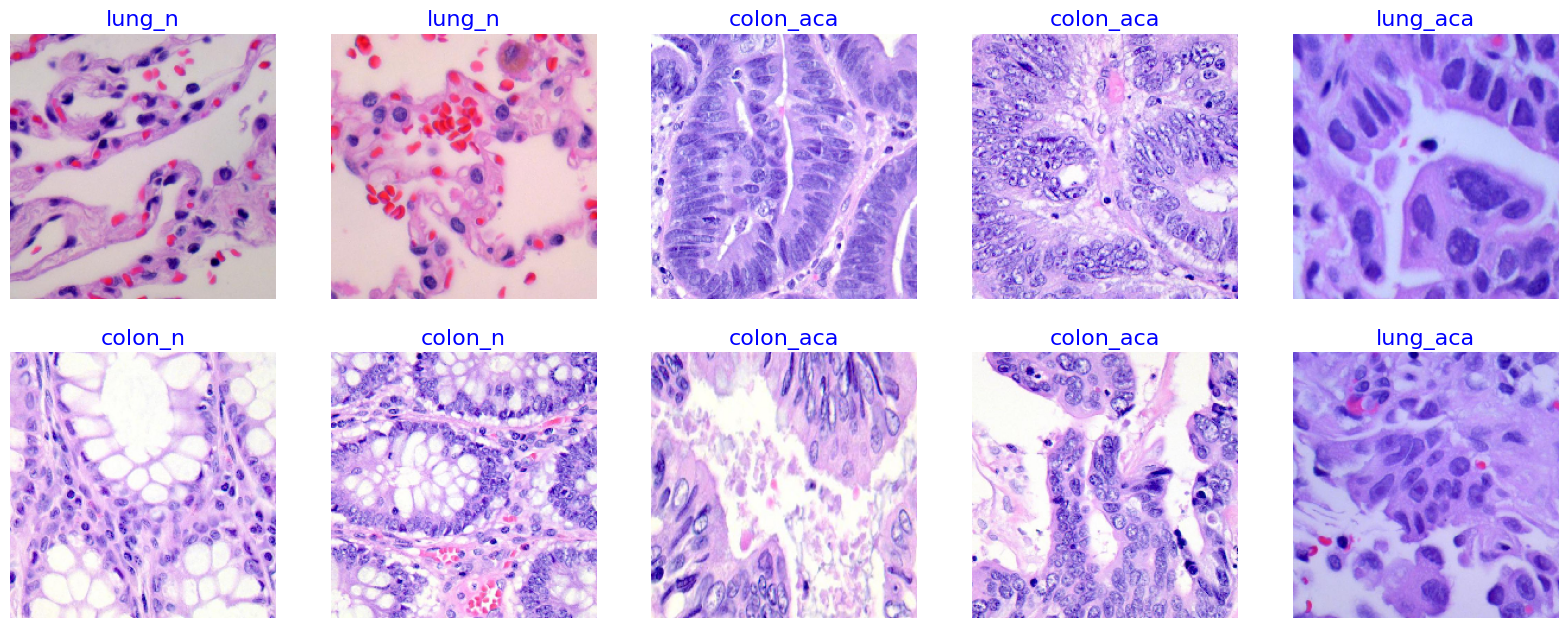

In [8]:
show_image_samples(train_gen)

In [9]:
IMG_SIZE=224

In [10]:
num_classes=len(classes)
print(num_classes)

5


EarlyStopping helps in reducing overfit and  time taken implement a model  

In [11]:
from tensorflow.keras.callbacks import EarlyStopping

# Create an EarlyStopping callback
early_stopping = EarlyStopping(
    monitor='val_loss',  # Monitor the validation loss
    patience=5,           # Number of epochs with no improvement after which training will be stopped
    verbose=2,
    restore_best_weights='True',
    mode='auto'  # Restore model weights to the best observed during training
)




## Defining Models

## Basic CNN Model

In [18]:
from tensorflow.keras.metrics import Recall
model1 = Sequential()
model1.add(layers.Conv2D(filters=16, kernel_size=(3, 3), strides=1, padding="SAME", activation='relu', input_shape=(224, 224, 3)))
model1.add(layers.MaxPooling2D(pool_size= (3, 3), strides=2, padding="VALID"))
model1.add(layers.Conv2D(filters=128, kernel_size=(3, 3), strides=1, padding="SAME", activation='relu'))
model1.add(layers.MaxPooling2D(pool_size= (3, 3), strides=2, padding="VALID"))
model1.add(layers.Flatten())
model1.add(layers.Dense(256, activation='relu'))
model1.add(layers.Dense(5, activation='softmax'))
model1.compile(Adam(learning_rate=.001), loss='categorical_crossentropy', metrics=['accuracy', Recall()])

In [23]:
model1.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 224, 224, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 111, 111, 16)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 111, 111, 128)     18560     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 55, 55, 128)      0         
 2D)                                                             
                                                                 
 flatten_1 (Flatten)         (None, 387200)            0         
                                                                 
 dense_2 (Dense)             (None, 256)              

In [19]:
history_base= model1.fit(
    train_gen,
    epochs=10,                
    validation_data=valid_gen,
    callbacks=[early_stopping]  # Pass the EarlyStopping callback
)

Epoch 1/10
625/625 [==============================] - 104s 163ms/step - loss: 0.6813 - accuracy: 0.8332 - recall_1: 0.8221 - val_loss: 0.2024 - val_accuracy: 0.9208 - val_recall_1: 0.9188
Epoch 2/10
625/625 [==============================] - 93s 149ms/step - loss: 0.1508 - accuracy: 0.9441 - recall_1: 0.9434 - val_loss: 0.2269 - val_accuracy: 0.9228 - val_recall_1: 0.9216
Epoch 3/10
625/625 [==============================] - 101s 162ms/step - loss: 0.0786 - accuracy: 0.9711 - recall_1: 0.9706 - val_loss: 0.2378 - val_accuracy: 0.9164 - val_recall_1: 0.9160
Epoch 4/10
625/625 [==============================] - 98s 157ms/step - loss: 0.0474 - accuracy: 0.9825 - recall_1: 0.9824 - val_loss: 0.2547 - val_accuracy: 0.9328 - val_recall_1: 0.9328
Epoch 5/10
625/625 [==============================] - 98s 156ms/step - loss: 0.0354 - accuracy: 0.9870 - recall_1: 0.9869 - val_loss: 0.2553 - val_accuracy: 0.9432 - val_recall_1: 0.9424
Epoch 6/10
625/625 [==============================] - 95s 153ms

## MobileNet 

In [12]:
from tensorflow.keras.applications import MobileNet

base_model = MobileNet(
        weights='imagenet',
        include_top=False,
        input_shape=(224, 224, 3)
    )
model = Sequential()
model.add(base_model)
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dense(5, activation='softmax'))

17225924/17225924 [==============================] - 1s 0us/step


In [13]:
model.compile(Adam(learning_rate=.001), loss='categorical_crossentropy', metrics=['accuracy', Recall()])


In [24]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenet_1.00_224 (Functio  (None, 7, 7, 1024)       3228864   
 nal)                                                            
                                                                 
 flatten (Flatten)           (None, 50176)             0         
                                                                 
 dense (Dense)               (None, 256)               12845312  
                                                                 
 dense_1 (Dense)             (None, 5)                 1285      
                                                                 
Total params: 16,075,461
Trainable params: 16,053,573
Non-trainable params: 21,888
_________________________________________________________________


In [14]:
history= model.fit(
    train_gen,
    epochs=10,                # You can adjust the number of epochs
    validation_data=valid_gen,
    callbacks=[early_stopping]  # Pass the EarlyStopping callback
)

Epoch 1/10
625/625 [==============================] - 230s 332ms/step - loss: 0.5615 - accuracy: 0.9445 - recall: 0.9405 - val_loss: 0.0501 - val_accuracy: 0.9836 - val_recall: 0.9820
Epoch 2/10
625/625 [==============================] - 100s 160ms/step - loss: 0.0906 - accuracy: 0.9765 - recall: 0.9753 - val_loss: 0.2581 - val_accuracy: 0.9392 - val_recall: 0.9364
Epoch 3/10
625/625 [==============================] - 102s 164ms/step - loss: 0.0844 - accuracy: 0.9758 - recall: 0.9747 - val_loss: 0.4582 - val_accuracy: 0.9000 - val_recall: 0.8992
Epoch 4/10
625/625 [==============================] - 104s 166ms/step - loss: 0.0414 - accuracy: 0.9867 - recall: 0.9864 - val_loss: 0.0639 - val_accuracy: 0.9736 - val_recall: 0.9732
Epoch 5/10
625/625 [==============================] - 101s 162ms/step - loss: 0.0339 - accuracy: 0.9892 - recall: 0.9890 - val_loss: 0.0286 - val_accuracy: 0.9908 - val_recall: 0.9888
Epoch 6/10
625/625 [==============================] - 101s 161ms/step - loss: 0.

## VGG19 Model

In [20]:
from tensorflow.keras.applications import VGG19


base_model1 = VGG19(weights='imagenet', input_shape=(224, 224, 3), include_top=True)

model_VGG19 = Sequential()
model_VGG19.add(base_model1)
model_VGG19.add(Flatten())
model_VGG19.add(Dense(256, activation='relu',kernel_regularizer=l2(0.0001)))
model_VGG19.add(Dense(5, activation='softmax'))

574710816/574710816 [==============================] - 20s 0us/step


In [21]:
model_VGG19.compile(Adam(learning_rate=.001), loss='categorical_crossentropy', metrics=['accuracy', Recall()])

In [22]:
history_alex= model_VGG19.fit(
    train_gen,
    epochs=10,                # You can adjust the number of epochs
    validation_data=valid_gen,
    callbacks=[early_stopping]  # Pass the EarlyStopping callback
)

Epoch 1/10
625/625 [==============================] - 182s 272ms/step - loss: 1.6119 - accuracy: 0.1973 - recall_2: 0.0000e+00 - val_loss: 1.6097 - val_accuracy: 0.2032 - val_recall_2: 0.0000e+00
Epoch 2/10
625/625 [==============================] - 168s 269ms/step - loss: 1.6101 - accuracy: 0.1973 - recall_2: 0.0000e+00 - val_loss: 1.6098 - val_accuracy: 0.2056 - val_recall_2: 0.0000e+00
Epoch 3/10
625/625 [==============================] - 168s 269ms/step - loss: 1.6098 - accuracy: 0.1977 - recall_2: 0.0000e+00 - val_loss: 1.6096 - val_accuracy: 0.1968 - val_recall_2: 0.0000e+00
Epoch 4/10
625/625 [==============================] - 169s 270ms/step - loss: 1.6097 - accuracy: 0.1973 - recall_2: 0.0000e+00 - val_loss: 1.6096 - val_accuracy: 0.1968 - val_recall_2: 0.0000e+00
Epoch 5/10
625/625 [==============================] - 168s 269ms/step - loss: 1.6097 - accuracy: 0.1941 - recall_2: 0.0000e+00 - val_loss: 1.6094 - val_accuracy: 0.2032 - val_recall_2: 0.0000e+00
Epoch 6/10
625/625 [

| Model          |    Validation Recall |
|----------------|--------------------  |
| Mobilenet      |     0.9532           |
| Simple CNN     |     0.9416           | 
| VGG19          |     0.0000           |


****From the above we can conclude on our dataset MobileNet is Best among all. So for Testing We are using Mobilenet model.****

## Loss Graph of final Models

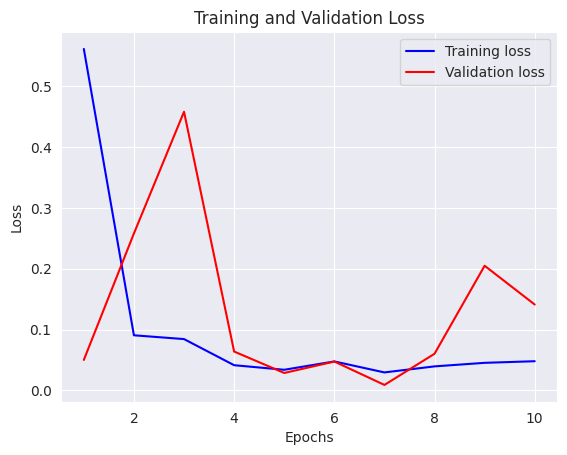

In [17]:
import matplotlib.pyplot as plt

loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss)+1)
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

## Testing on test datasets 

50/50 [==============================] - 25s 487ms/step


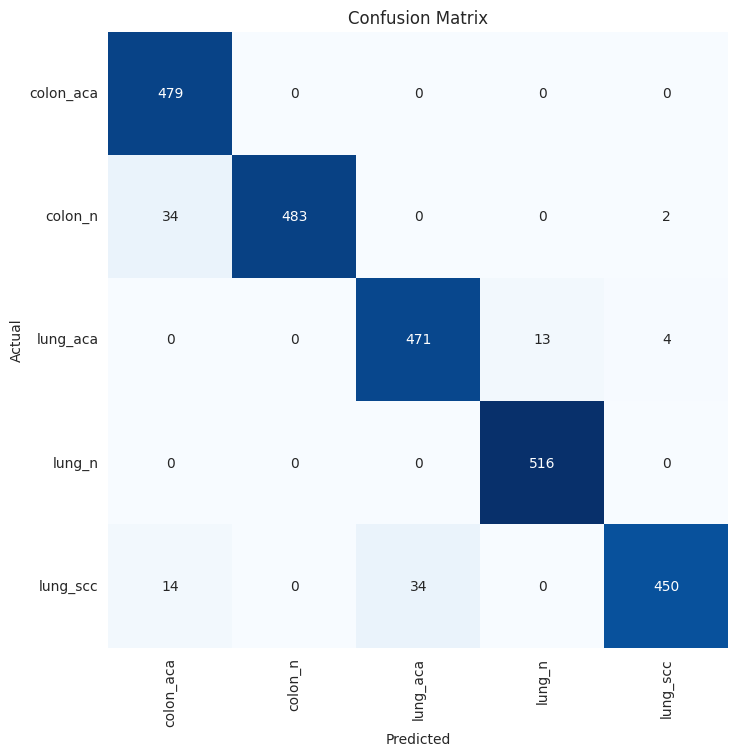

In [15]:
from sklearn.metrics import confusion_matrix
import numpy as np

# Assuming you have a model and a test data generator (test_gen)

# Get true labels from the test data generator
true_labels = test_gen.classes

# Make predictions using your model
predictions = model.predict(test_gen)

# Convert predicted probabilities to class indices
predicted_labels = np.argmax(predictions, axis=1)

cm = confusion_matrix(true_labels, predicted_labels )        
length=len(classes)
if length<8:
    fig_width=8
    fig_height=8
else:
    fig_width= int(length * .5)
    fig_height= int(length * .5)
plt.figure(figsize=(fig_width, fig_height))
sns.heatmap(cm, annot=True, vmin=0, fmt='g', cmap='Blues', cbar=False)       
plt.xticks(np.arange(length)+.5, classes, rotation= 90)
plt.yticks(np.arange(length)+.5, classes, rotation=0)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

In [16]:
clr = classification_report(true_labels, predicted_labels, target_names=classes)
print("Classification Report:\n----------------------\n", clr)

Classification Report:
----------------------
               precision    recall  f1-score   support

   colon_aca       0.91      1.00      0.95       479
     colon_n       1.00      0.93      0.96       519
    lung_aca       0.93      0.97      0.95       488
      lung_n       0.98      1.00      0.99       516
    lung_scc       0.99      0.90      0.94       498

    accuracy                           0.96      2500
   macro avg       0.96      0.96      0.96      2500
weighted avg       0.96      0.96      0.96      2500

